In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

image1 = cv2.imread('left_half_set6_1.tif')
image2 = cv2.imread('right_half_set6_1.tif')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Apply Harris Corner Detector to both images
corner_detector1 = cv2.cornerHarris(gray1, blockSize=2, ksize=3, k=0.04)
corner_detector2 = cv2.cornerHarris(gray2, blockSize=2, ksize=3, k=0.04)

In [2]:
threshold = 0.01
corners1 = np.column_stack(np.where(corner_detector1 > threshold * corner_detector1.max()))
corners2 = np.column_stack(np.where(corner_detector2 > threshold * corner_detector2.max()))

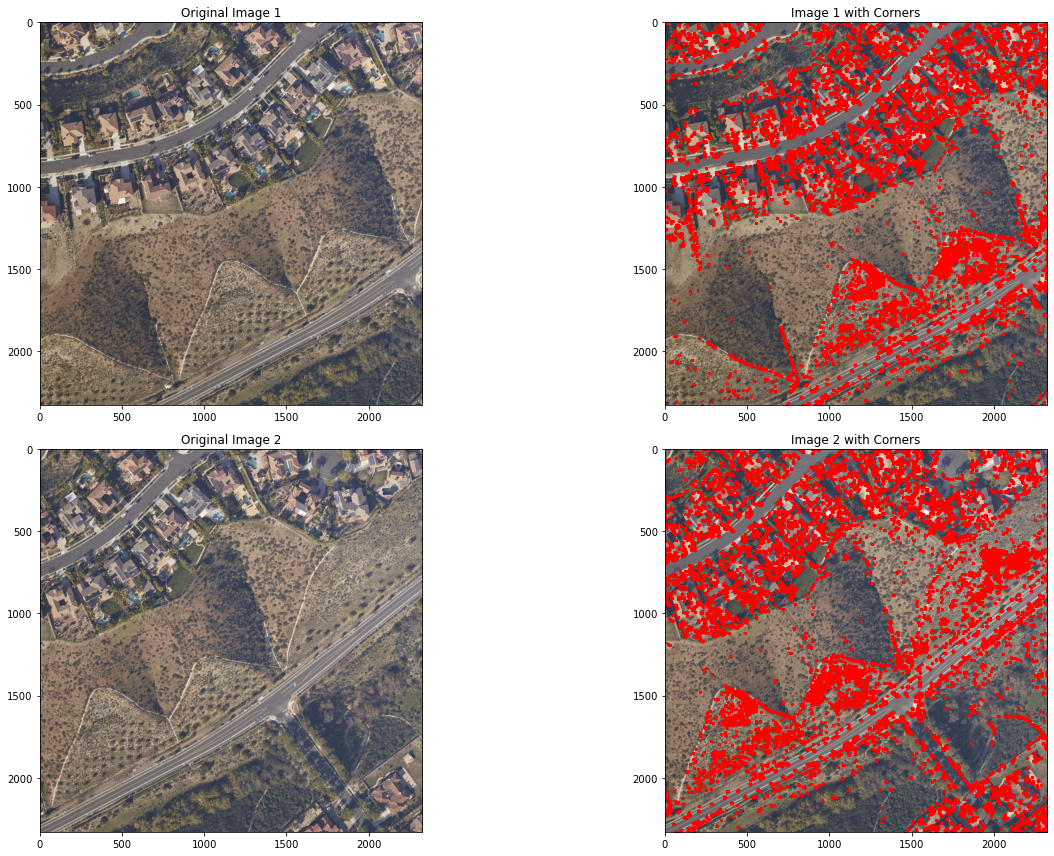

In [3]:
plt.figure(figsize=(20, 12))

# Original Image 1
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

# Scatter plot for Image 1 corners
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.scatter(corners1[:, 1], corners1[:, 0], c='r', marker='o', s=5)
plt.title('Image 1 with Corners')

# Original Image 2
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Original Image 2')

# Scatter plot for Image 2 corners
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.scatter(corners2[:, 1], corners2[:, 0], c='r', marker='o', s=5)
plt.title('Image 2 with Corners')

plt.tight_layout()
plt.show()

In [4]:
# Use Harris corners as keypoints
keypoints1 = [cv2.KeyPoint(float(pt[1]), float(pt[0]), 1) for pt in np.argwhere(corner_detector1 > threshold * corner_detector1.max())]
keypoints2 = [cv2.KeyPoint(float(pt[1]), float(pt[0]), 1) for pt in np.argwhere(corner_detector2 > threshold * corner_detector2.max())]



In [5]:
# Initialize SIFT
sift = cv2.SIFT_create()

# Compute SIFT descriptors for the keypoints
_, descriptors1 = sift.compute(gray1, keypoints1)
_, descriptors2 = sift.compute(gray2, keypoints2)

In [6]:
# Use a FLANN based Matcher to find matches
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to get good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract corresponding points
points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

In [7]:
# Find the perspective transformation matrix
M, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

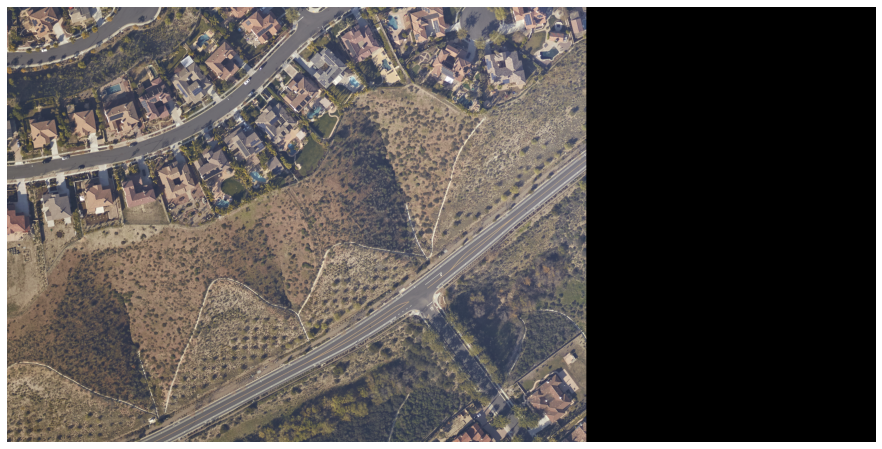

In [8]:
# Get the dimensions of the first image
h1, w1 = image1.shape[:2]

# Warp the second image to align with the first
warped_image2 = cv2.warpPerspective(image2, M, (w1 + image2.shape[1], h1))

# Combine the two images
result = np.copy(warped_image2)
result[:h1, :w1] = image1

canvas_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# Display the result
plt.figure(figsize=(20,8))
plt.imshow(canvas_rgb)
plt.axis('off')
plt.show()